## Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks##


### Contribution
1. set constraints on Convolutional GANs to make it stable.
2. use trained discriminator for image classification tasks
3. visualize the filters of GANs and show how different fliters have learnt to draw specific objects

### Model Architecture
- General Idea: `DCGAN ≈ CNN + GAN`
- Change `G` and `D` in original GAN to **two CNN** with some procedures, taking advantages of the *features extraction* learning ability of CNN.
   - Use `batch normalization` in generator and discriminator, except applied in the output layer of G and the input layer of D for avoiding sample oscillation and model instability.
   - Replace any <u>pooling layers</u> with strided convolutions(discriminator) and fractional-strided convolutions(generator)->Transposed Convolution layer
     - `Stride`: the number of pixels shift over the input matrix.
     - allow network to learn its own spatial downsampling.
   - Remove `FC hidden layers` for deeper architecture
      - for discriminator, the last convLayer is flattened and fed to a single <u>sigmoid</u> output.
   - Use `ReLU` in **generator** for all *input* and *hidden layers*, for *output* layer use `Tanh`.
   - Use `LeakyReLU` in discriminator for all layers.

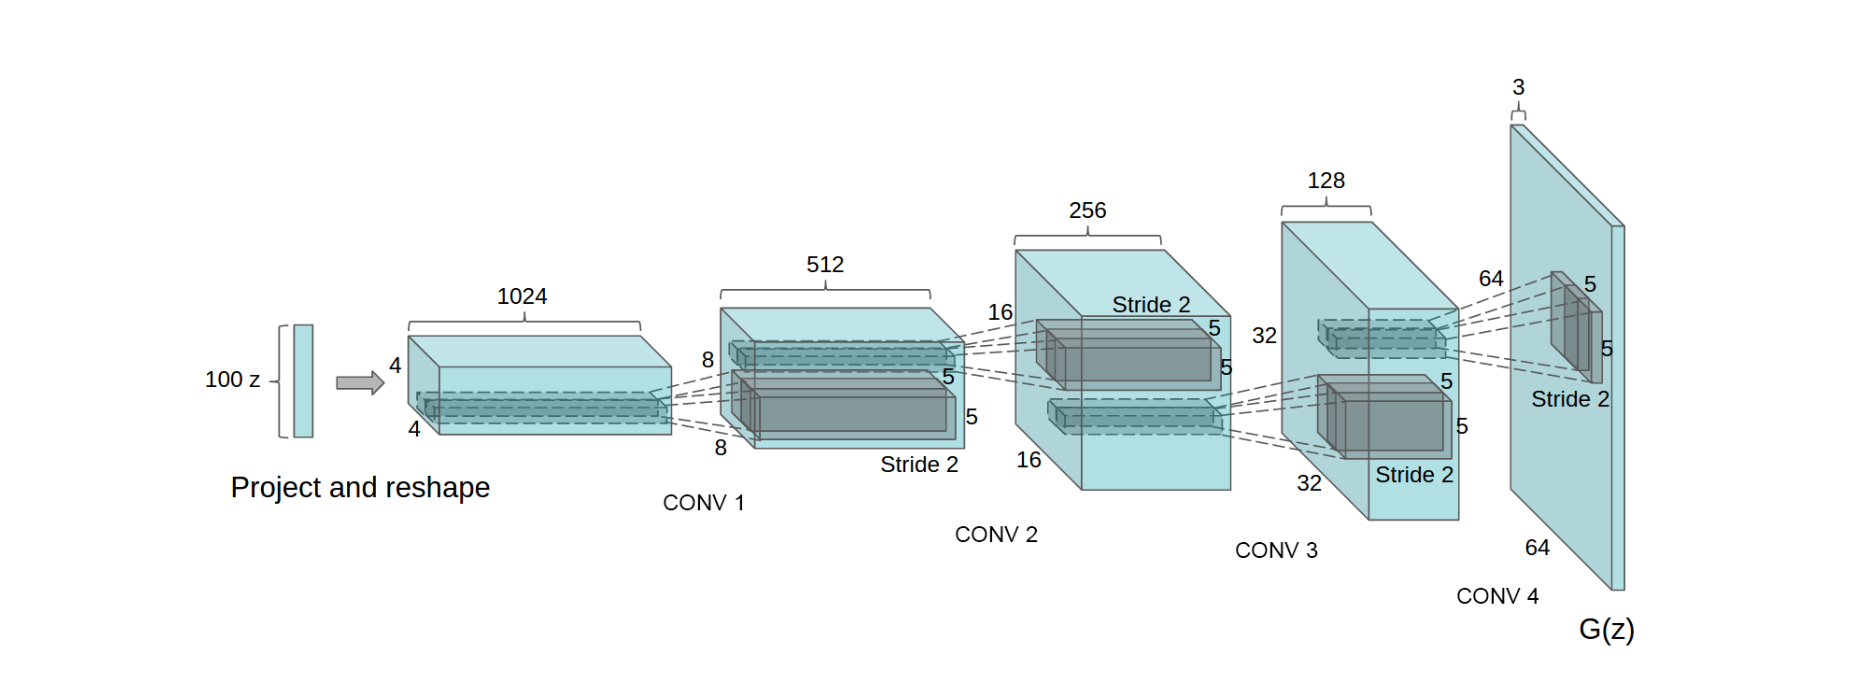

### Training Procedure
- No pre-processing applied,tahn sets image scale into [-1, 1].
- use three datasets
- trained with mini-batch SGD with size of 128
- Weight intialization: $W~Normal(μ=0,σ=0.02)$
- LeakyReLU: the slope of leak=0.2
- Hyperparameter Tuning: use Adam
- learning rate= 0.0002
- To accelerate training use momentum动量, set $β_1=0.5$ to stablize training.

### CNN
#### Application
- image recognition, image classification, object recognition, face recognition
- input image as RGB or grayscale 3-dimensional array
- Structure: take image classification as example
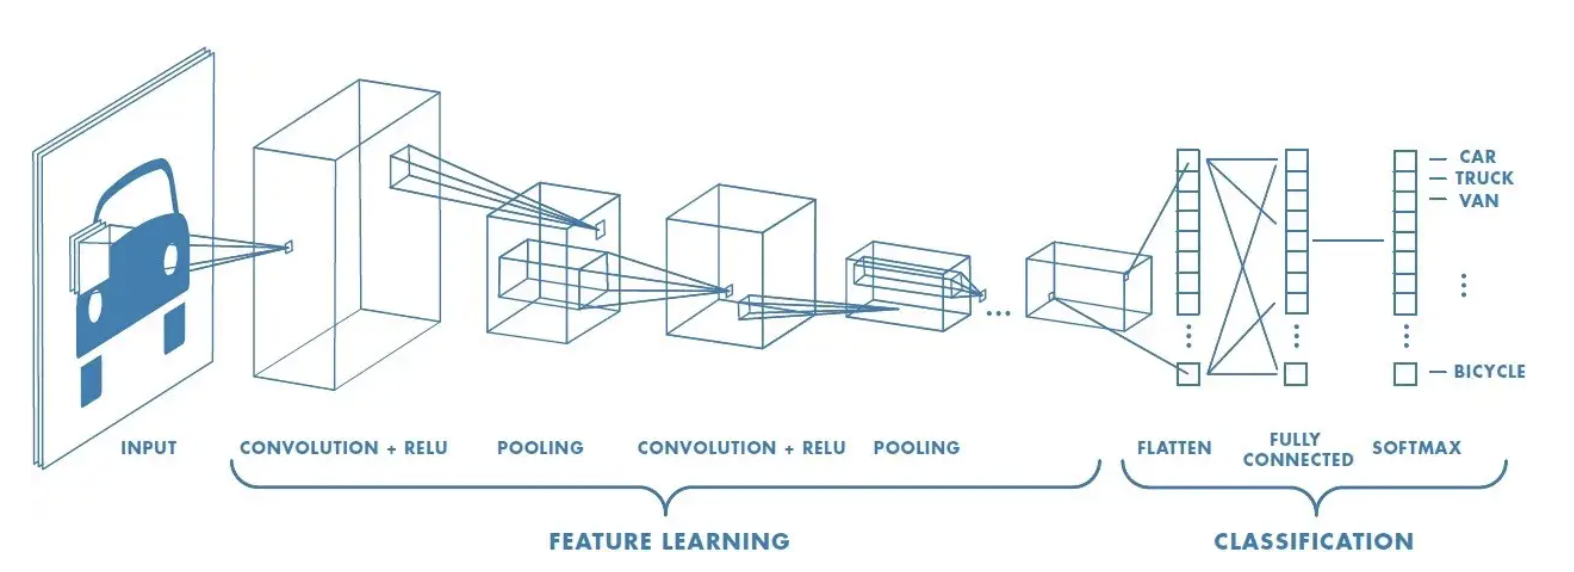

#### Concepts
1. **Convolution layer**: extract features, takes *image matrix* and *filter matrix* as input, get `feature map` as output.
   - filters effects: perform operations such as edge detection, blur, or sharpen.
   - Types of filter: Identity, Edge Detection, Sharpen, Box blur, Gaussian blur.
2. **ReLU**: non-linear operation
   - function: $f(x)=max(0,x)$
3. **Pooling layer**: reduce dimensionality size.
   - reduce # of parameters to learn and computation performed in the network but keep the important information
   - it focus on summarize features generated by convolution layer
   - Types:
     - Max Pooling
     - Average Pooling
     - Global Pooling
  - Called `spatial pooling`, `subsampling`, `downsampling`
4. **Fully Connected Layer(FC)**
   - the neuron applies a linear transformation with activation function($f$) to the input vector($x$) throught the weight matrix($W$)
   - every input influences every output, operates on a flattened input where each input is connected to all neurals.
5. **Padding**: use it when filter cannot fit the input image well
   - pad the pic with 0s--`zero padding`
   - drop the part of image where filter does not fit--`valid padding`


### References
- Convolutional Neural Networks cheatsheet.http://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
- Understanding of Convolutional Neural Network(CNN)--Deep Learning.http://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148
- DCGAN to generate face images.https://keras.io/examples/generative/dcgan_overriding_train_step/
- 20.2.Deep Convolutional Generative Adverisarial Networks.https://d2l.ai/chapter_generative-adversial-networks/dcgan.html
- Tensorflow Documentation.https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose


## Coding Project: Establish a DCGAN for Image Generation

#### Initialization

In [65]:
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.preprocessing import MinMaxScaler #scaling inputs used in the generator and discriminator
import cv2
import matplotlib.pyplot as plt
import graphviz #showing model diagram
import tensorflow as tf
from tensorflow import keras
from keras import Model, Sequential 
from keras.layers import Input,Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout,BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

#### Dataset Import
- Data Source: https://data.caltech.edu/records/mzrjq-6wc02
   - size: 300 x 200 pixels. 
   - We only use "Faces_easy.zip" file as data input.

In [48]:
!unzip "/content/Faces_easy.zip"

Archive:  /content/Faces_easy.zip
replace __MACOSX/._Faces_easy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._Faces_easy   
replace Faces_easy/image_0146.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Faces_easy/image_0146.jpg  
replace __MACOSX/Faces_easy/._image_0146.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
#define the dimension of input image and training
H=64
W=64
C=3
batch_size=128
input_dim=100

In [67]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/Faces_easy',image_size=(H, W),batch_size=batch_size,label_mode=None)
#apply the lambda function on training dataset to normalize the inputs from [0,255] to [-1,1]
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = trainDataset.map(lambda x: normalization_layer(x))

Found 435 files belonging to 1 classes.


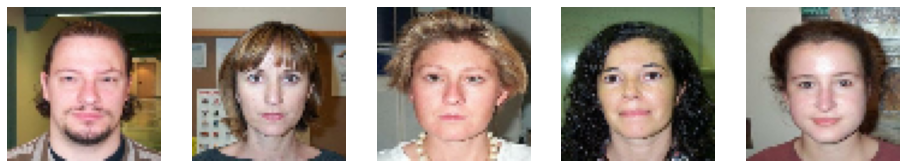

In [51]:
#define the helper function to illustration
def plot_array(X,title=""):
    plt.rcParams['figure.figsize'] = (16,9) 
    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")
    plt.show()
#plot the first five images in batch
images=trainDataset.take(1)
X=[x for x in images]
plot_array(X[0])

#### Generator
- a decoder to be fed with 100 dimenisons latent vector, then output a image dimension 64x64x3 .

In [52]:
def make_generator():
    model=Sequential()
    # Input Layer
    model.add(Input(shape=(1, 1, 100), name='input_layer'))
    
    # Block1
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block2
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block3
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))
                
    # Block4
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    #Output Layer
    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_5'))

    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_transpose_1 (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 4, 4, 512)         2048      
                                                                 
 relu_1 (ReLU)               (None, 4, 4, 512)         0         
                                                                 
 conv_transpose_2 (Conv2DTra  (None, 8, 8, 256)        2097152   
 nspose)                                                         
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                                 
 relu_2 (ReLU)               (None, 8, 8, 256)        

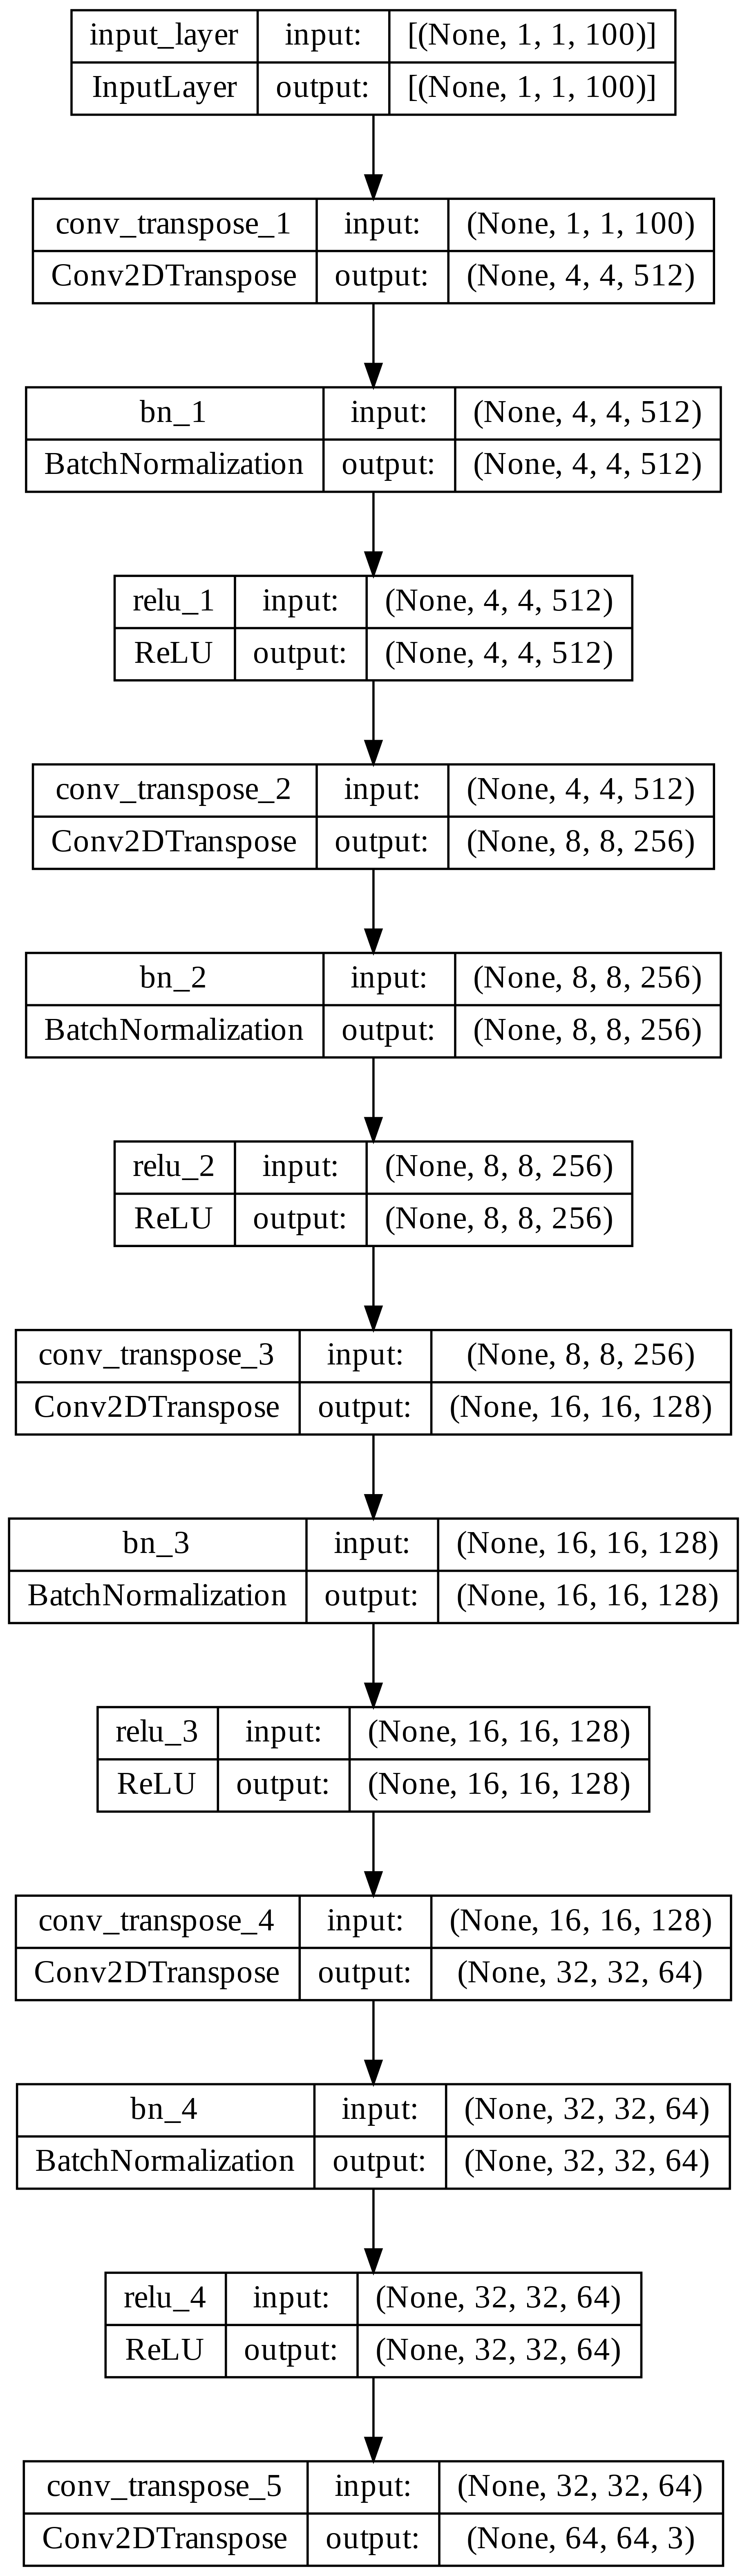

In [53]:
gen = make_generator()
gen.summary()
plot_model(gen, show_shapes=True, show_layer_names=True, dpi=400)

#### Discriminor

In [54]:
def make_discriminator():
    model=Sequential()
    # Block 1
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,  
                     activation='sigmoid', name='conv_5'))

    return model 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 128)       131072    
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 128)       512       
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)        

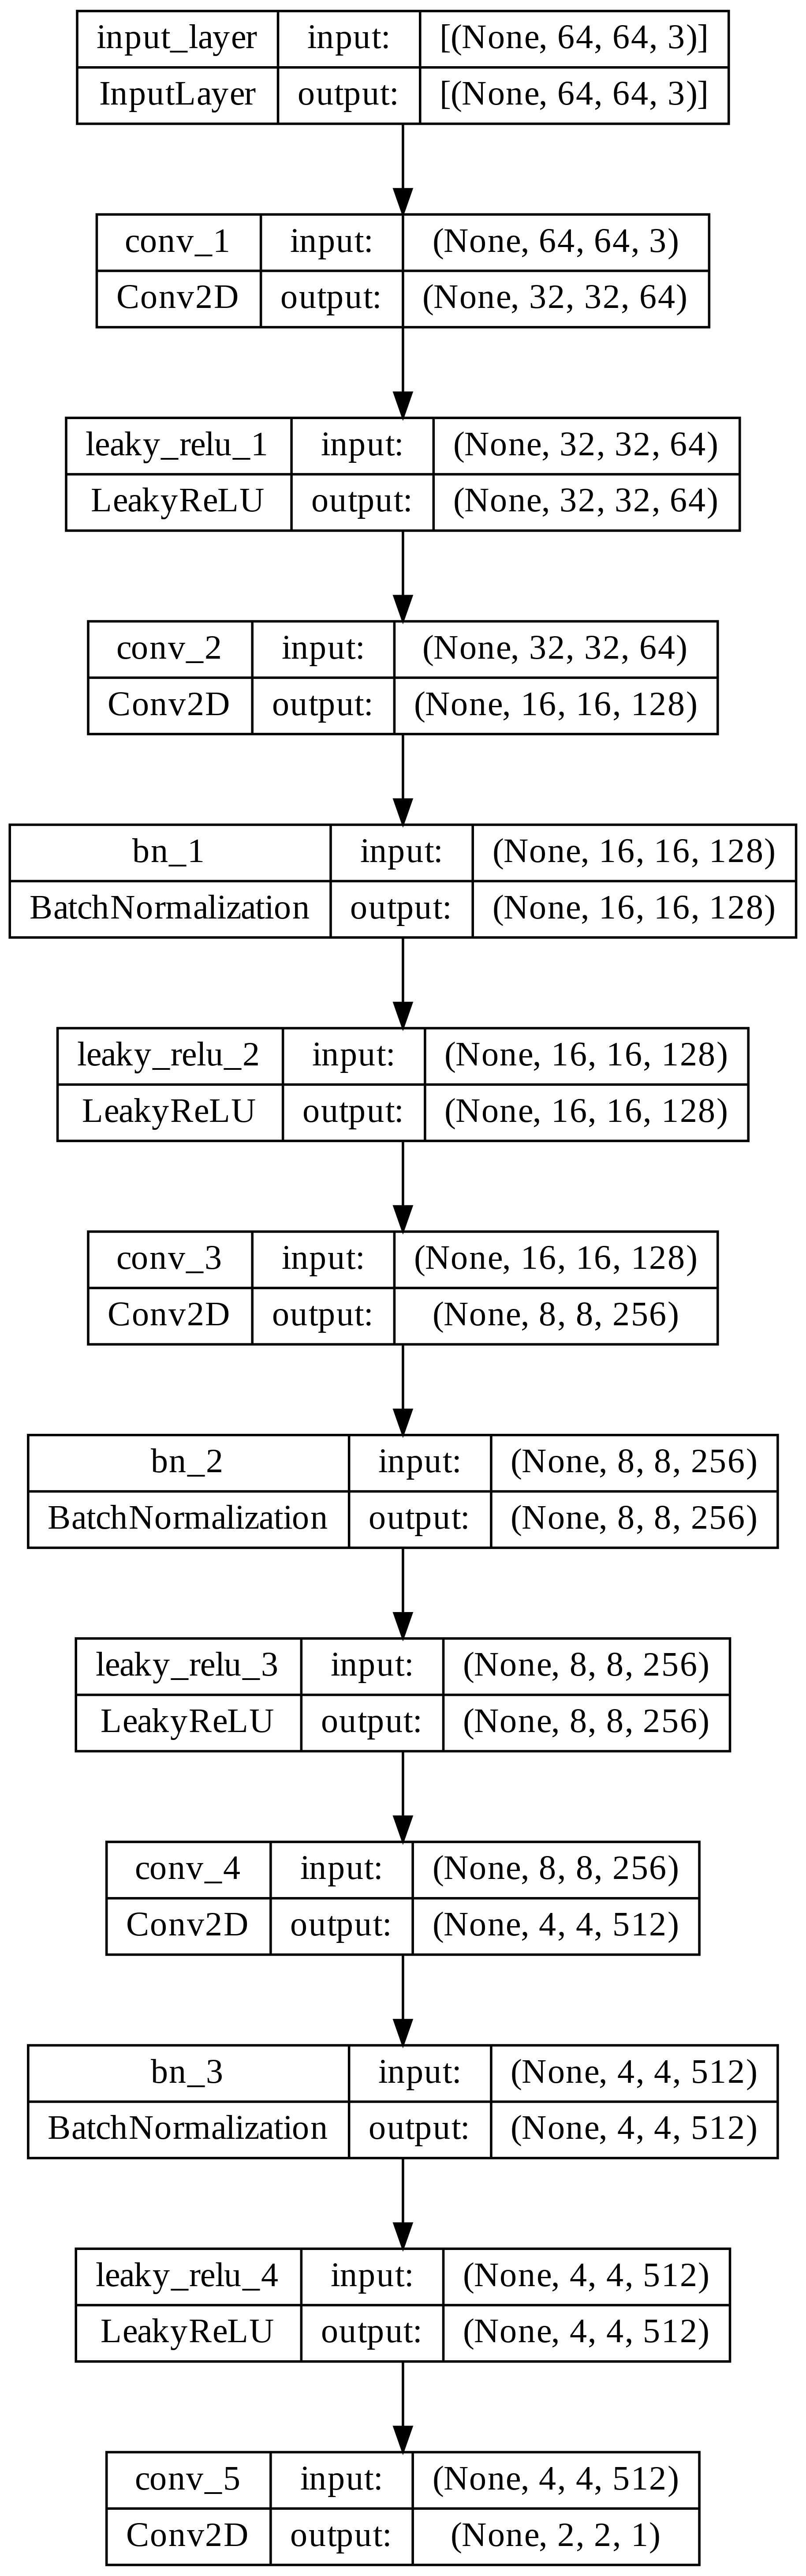

In [55]:
disc = make_discriminator()
disc.summary()
plot_model(disc, show_shapes=True, show_layer_names=True, dpi=400)

#### Loss Function

In [56]:
loss=tf.keras.losses.BinaryCrossentropy()

In [57]:
#Generator Loss
def generator_loss(Xhat):
  return loss(tf.ones_like(Xhat),Xhat)

In [58]:
#discriminator Loss
def discriminator_loss(X, Xhat):
  real_loss=loss(tf.ones_like(X),X)
  fake_loss=loss(tf.ones_like(Xhat),Xhat)
  total_loss=0.5*(real_loss+fake_loss)
  return total_loss

#### Optimizer

In [59]:
generator_optimizer=tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [60]:
discriminator_optimizer=tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

#### Create the Training Step

In [62]:
@tf.function
def train_step(X):
  #noise with normal distribution
  z=tf.random.normal([batch_size,1,1,input_dim])
  #Compute the gradients
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #generated sample
    xhat=generator(z,training=True)
    #the output of discriminator for real data
    real_output=discriminator(X,training=True)
    #the output of discriminator for fake data
    fake_output=discriminator(xhat,training=True)
    #loss 
    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)
  #get the gradients for gen_loss and generator
  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)


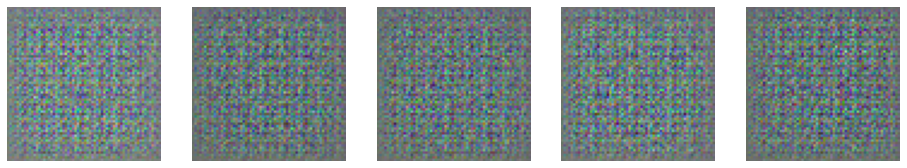

In [63]:
generator= make_generator()
batch_size=128
input_dim=100
noise = tf.random.normal([batch_size, 1, 1, input_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

#### Training DCGAN Model

epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 1, iteration 1


epoch 1:  25%|██▌       | 1/4 [00:03<00:09,  3.01s/it]

epoch 1, iteration 2


epoch 1:  50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

epoch 1, iteration 3


epoch 1:  75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

epoch 1, iteration 4


epoch 1: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


orignal images


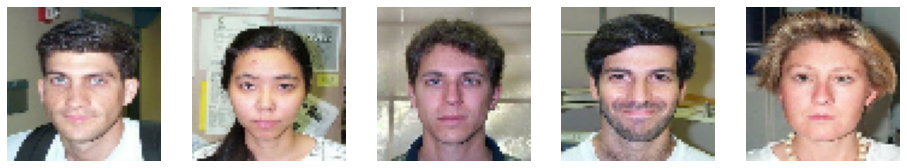

generated images


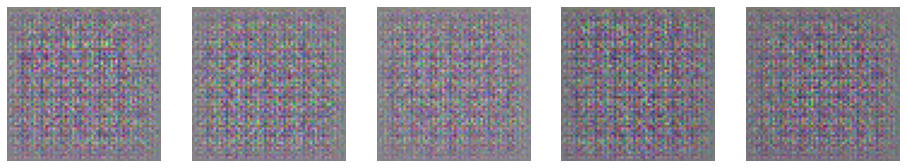

Time for epoch 1 is 13.225423336029053 sec


epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 2, iteration 1


epoch 2:  25%|██▌       | 1/4 [00:03<00:09,  3.02s/it]

epoch 2, iteration 2


epoch 2:  50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

epoch 2, iteration 3


epoch 2:  75%|███████▌  | 3/4 [00:08<00:02,  2.72s/it]

epoch 2, iteration 4


epoch 2: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


orignal images


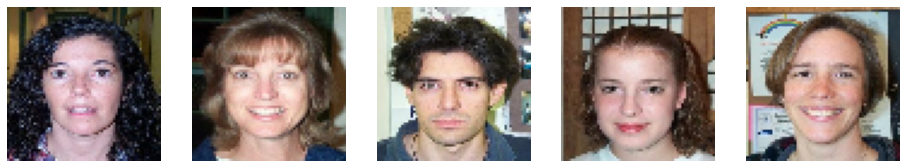

generated images


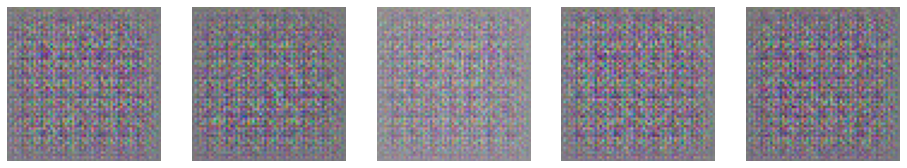

Time for epoch 2 is 13.678603172302246 sec


epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 3, iteration 1


epoch 3:  25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

epoch 3, iteration 2


epoch 3:  50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

epoch 3, iteration 3


epoch 3:  75%|███████▌  | 3/4 [00:08<00:02,  2.68s/it]

epoch 3, iteration 4


epoch 3: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


orignal images


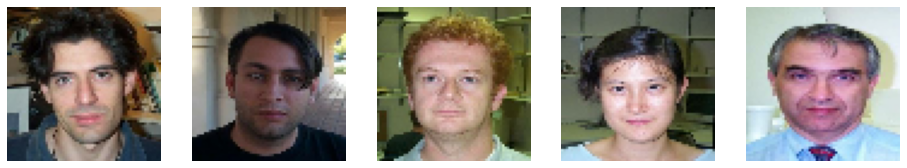

generated images


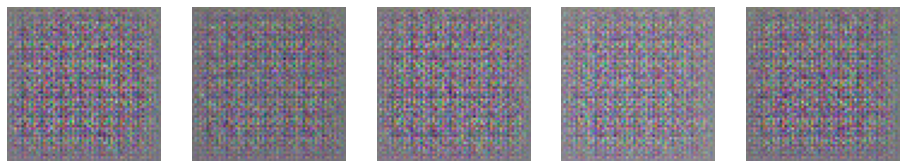

Time for epoch 3 is 13.029677391052246 sec


epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 4, iteration 1


epoch 4:  25%|██▌       | 1/4 [00:03<00:09,  3.04s/it]

epoch 4, iteration 2


epoch 4:  50%|█████     | 2/4 [00:05<00:05,  2.79s/it]

epoch 4, iteration 3


epoch 4:  75%|███████▌  | 3/4 [00:08<00:02,  2.70s/it]

epoch 4, iteration 4


epoch 4: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


orignal images


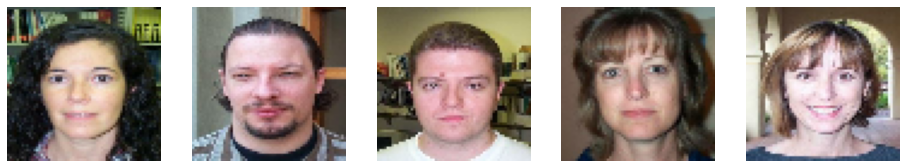

generated images


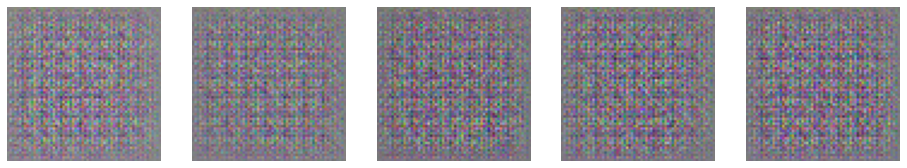

Time for epoch 4 is 13.176700592041016 sec


epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 5, iteration 1


epoch 5:  25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]

epoch 5, iteration 2


epoch 5:  50%|█████     | 2/4 [00:06<00:06,  3.29s/it]

epoch 5, iteration 3


epoch 5:  75%|███████▌  | 3/4 [00:09<00:02,  3.00s/it]

epoch 5, iteration 4


epoch 5: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


orignal images


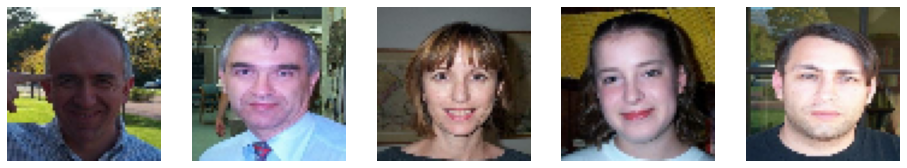

generated images


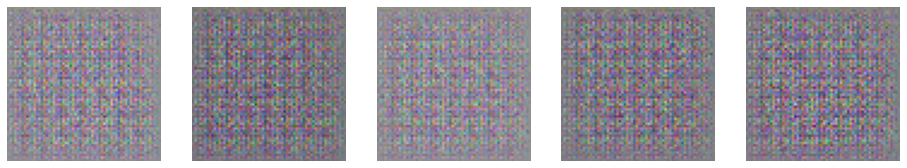

Time for epoch 5 is 14.480984926223755 sec


epoch 6:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 6, iteration 1


epoch 6:  25%|██▌       | 1/4 [00:02<00:08,  2.99s/it]

epoch 6, iteration 2


epoch 6:  50%|█████     | 2/4 [00:05<00:05,  2.79s/it]

epoch 6, iteration 3


epoch 6:  75%|███████▌  | 3/4 [00:08<00:02,  2.75s/it]

epoch 6, iteration 4


epoch 6: 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


orignal images


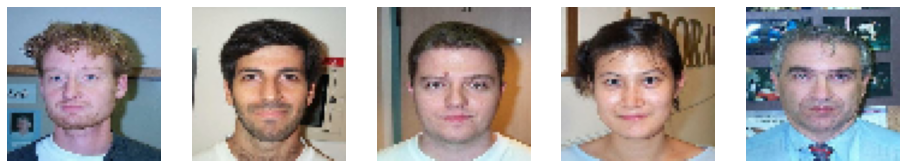

generated images


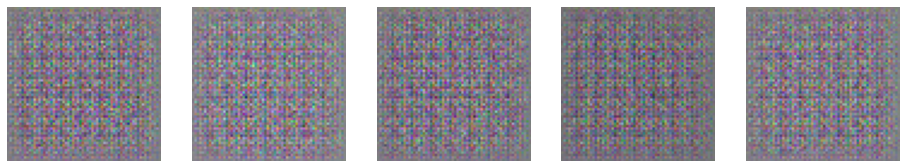

Time for epoch 6 is 13.321374893188477 sec


epoch 7:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 7, iteration 1


epoch 7:  25%|██▌       | 1/4 [00:03<00:09,  3.09s/it]

epoch 7, iteration 2


epoch 7:  50%|█████     | 2/4 [00:05<00:05,  2.84s/it]

epoch 7, iteration 3


epoch 7:  75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

epoch 7, iteration 4


epoch 7: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


orignal images


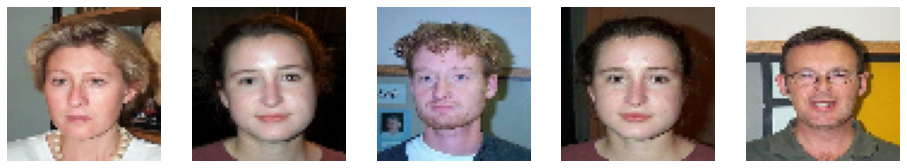

generated images


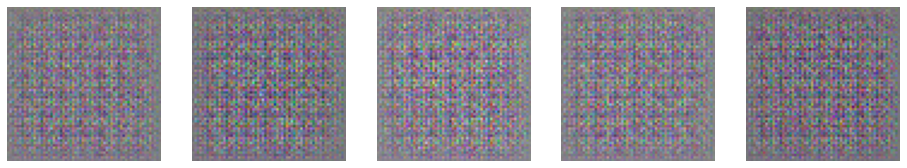

Time for epoch 7 is 13.514793157577515 sec


epoch 8:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 8, iteration 1


epoch 8:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

epoch 8, iteration 2


epoch 8:  50%|█████     | 2/4 [00:05<00:05,  2.82s/it]

epoch 8, iteration 3


epoch 8:  75%|███████▌  | 3/4 [00:08<00:02,  2.76s/it]

epoch 8, iteration 4


epoch 8: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


orignal images


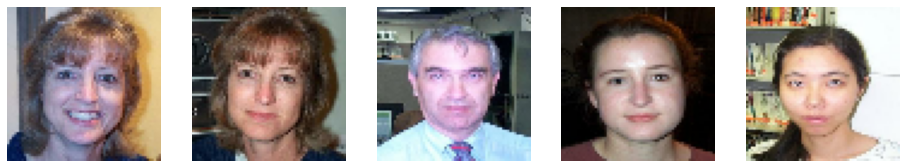

generated images


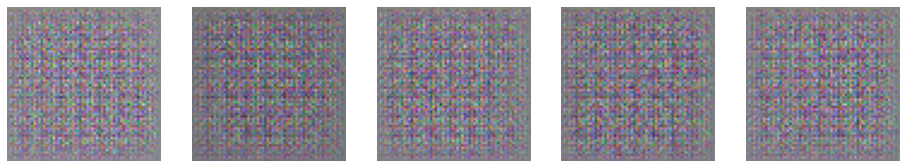

Time for epoch 8 is 13.878246307373047 sec


epoch 9:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 9, iteration 1


epoch 9:  25%|██▌       | 1/4 [00:03<00:09,  3.09s/it]

epoch 9, iteration 2


epoch 9:  50%|█████     | 2/4 [00:05<00:05,  2.85s/it]

epoch 9, iteration 3


epoch 9:  75%|███████▌  | 3/4 [00:10<00:03,  3.79s/it]

epoch 9, iteration 4


epoch 9: 100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


orignal images


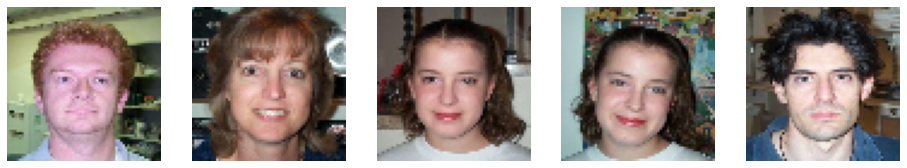

generated images


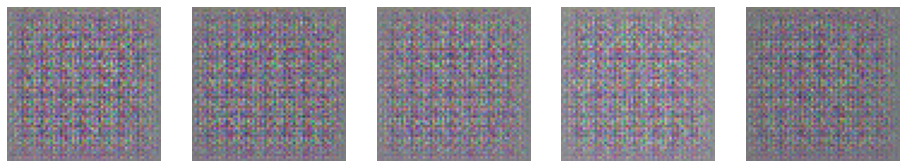

Time for epoch 9 is 17.646732807159424 sec


epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]

epoch 10, iteration 1


epoch 10:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

epoch 10, iteration 2


epoch 10:  50%|█████     | 2/4 [00:05<00:05,  2.88s/it]

epoch 10, iteration 3


epoch 10:  75%|███████▌  | 3/4 [00:08<00:02,  2.84s/it]

epoch 10, iteration 4


epoch 10: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


orignal images


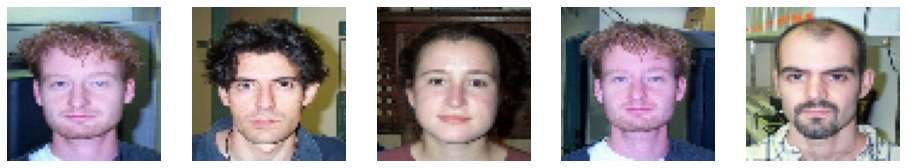

generated images


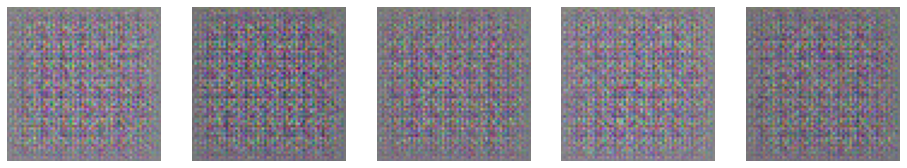

Time for epoch 10 is 13.737910032272339 sec


In [69]:
epochs=10
discriminator=make_discriminator()
generator= make_generator()

for epoch in range(epochs):
    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))
        train_step(X)
    noise = tf.random.normal([batch_size, 1, 1, input_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

The results are not demonstrated well, owing to the few epochs we set. If the epochs set to be 1000, the effects will be much better.